# <font color='blue'>Build the RNN</font>

Now that we all of the necessary ingredients, it's time to put the pieces together.

<font color='red'>**TODO:** Split up into smaller chunks and exercises.</font>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch: 1, loss: 5.17539310455

Seed: "Hello"
Orig: Hello, world!
Pred: tiiiiiiiiii

Seed: "Good "
Orig: Good bye now.
Pred: ttiiiiiiiii

--------------------------------------------------------------------------------
Epoch: 2, loss: 4.25486707687

Seed: "Good "
Orig: Good bye now.
Pred: Hi;;iiiiiiii;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;

Seed: "Hi ag"
Orig: Hi again!
Pred: Hiiiiiiiiiii;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;

--------------------------------------------------------------------------------
Epoch: 4, loss: 3.53653264046

Seed: "Hi ag"
Orig: Hi again!
Pred: Hiiiiiiiii

Seed: "Hello"
Orig: Hello, world!
Pred: HHiiiiiii

--------------------------------------------------------------------------------
E

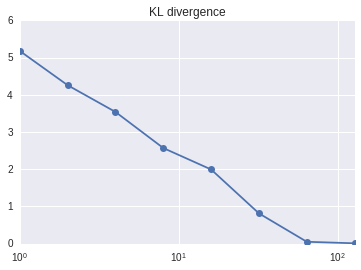

In [2]:
from utils import SentenceEncoder


# static shapes
n_hidden = 64
n_chars = 129  # ascii + EOS = 128 + 1 = 129
emb_dim = 13
batch_size = 2
warmup = 5

# clear any previous computation graph
tf.reset_default_graph()

# character embeddings
emb = tf.Variable(tf.random_uniform([n_chars, emb_dim], dtype=tf.float32))

# tf Graph input
seq_enc = tf.placeholder(tf.int32, [batch_size, None])  # (batch_size, max_seqlen_within_batch)
seq_mask = tf.placeholder(tf.bool, [batch_size, None])  # (batch_size, max_seqlen_within_batch)
max_seqlen = tf.placeholder(tf.int32, [])

# translate to dense vectors
x = tf.nn.embedding_lookup(emb, seq_enc)  # (batch_size, max_seqlen_within_batch, emb_dim])
x = tf.transpose(x, [1, 0, 2])            # tf.map_fn iterates over axis=0

# rnn cell
lstm_cell = tf.contrib.rnn.LSTMCell(n_hidden, num_proj=emb_dim, use_peepholes=True)

# memory cell states
c = tf.Variable(tf.random_uniform([1, n_hidden]))
m = tf.Variable(tf.random_uniform([1, emb_dim]))
c = tf.tile(c, [batch_size, 1])
m = tf.tile(m, [batch_size, 1])


def cond(i, h, c, m):
    return i < max_seqlen

def body(i, h, c, m):
    prev_token = tf.cond(
        i < warmup,
        lambda: x[i],
        lambda: tf.squeeze(h[-1])
    )
    
    h_new, (c, m) = lstm_cell(prev_token, (c, m))
    h_new = tf.expand_dims(h_new, 0)
    
    h = tf.concat([h, h_new], axis=0)
    i += 1
    return i, h, c, m


shape_invariants = map(tf.TensorShape, (
    [],                           # i.shape
    [None, batch_size, emb_dim],  # h.shape
    [batch_size, n_hidden],       # c.shape
    [batch_size, emb_dim],        # m.shape
))

# run while loop
h = tf.zeros([0, batch_size, emb_dim])
h = tf.while_loop(cond, body, [0, h, c, m], shape_invariants)[1]

# use Gaussian kernel for inter-embedding distances
d = tf.norm(tf.map_fn(lambda e: h - e, emb), axis=-1)  # shape = (n_chars, max_seqlen_within_batch, batch_size)
d = tf.transpose(d, [2, 1, 0])                         # shape = (batch_size, max_seqlen_within_batch, n_chars)

# define loss function
logits = -d ** 2                                         # shape = (batch_size, max_seqlen_within_batch, n_chars)
labels = tf.one_hot(seq_enc, n_chars, dtype=tf.float32)  # shape = (batch_size, max_seqlen_within_batch, n_chars)
loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits)
loss = tf.reduce_mean(tf.boolean_mask(loss, seq_mask))   # mask discards loss due to zero-padding

# get the most likely predicted characters
y_hat = tf.argmax(logits, axis=-1)  # shape = (batch_size, max_seqlen_within_batch)


   
def fit_model(sents, learning_rate=1e-2, n_epochs=128):
    """
    This function contains the usual boiler plate required to feed the
    input data and to print some training diagnostics.
    
    Params
    ------
    sents : sequence of strings
        The text on which to train / predict.
        
    learning_rate : float
        AdamOptimizer learning rate.
        
    n_epochs : int
        Numer of epochs to use at training time.
    
    """
    # optimizer
    train = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    encoder = SentenceEncoder(sents, batch_size=batch_size)

    with tf.Session() as s:
        s.run(tf.global_variables_initializer())
        learning_curve = {}
        for epoch in xrange(1, n_epochs + 1):
            for seq_enc_, seqlen_, seq_mask_, max_seqlen_ in encoder:
                _, loss_ = s.run(
                    (train, loss),
                    feed_dict={
                        seq_enc: seq_enc_,
                        seq_mask: seq_mask_,
                        max_seqlen: max_seqlen_})

            if np.log2(epoch).is_integer():
                print "Epoch: {}, loss: {}\n".format(epoch, loss_)
                learning_curve[epoch] = loss_

                # create prediction data
                seq_enc_ = list(encoder)[0][0][:2]  # get just two sentences
                seqlen_ = 100
                seq_mask_ = np.zeros([batch_size, seqlen_], dtype=np.bool)
                seed = np.zeros([batch_size, seqlen_], dtype=np.int32)
                seed[:,:warmup] = seq_enc_[:,:warmup]
                y_hat_ = s.run(
                    y_hat,
                    feed_dict={
                        seq_enc: seed,
                        seq_mask: seq_mask_,
                        max_seqlen: seqlen_})

                for s1, s2 in zip(encoder.decode(seq_enc_), encoder.decode(y_hat_)):
                    print "Seed: \"{}\"".format(s1[:warmup])
                    print "Orig: {}".format(s1)
                    print "Pred: {}\n".format(s2)

                print "-" * 80

    learning_curve = pd.Series(learning_curve)
    learning_curve.plot(logx=True, style='o-', title='KL divergence')


# some simple input sentences
sents = ["Hello, world!", "Hi again!", "Good bye now."]

fit_model(sents)